# **Final Project Dataset Adapter**

In this notebook, we will be working with a dataset introduced in the paper "Impact of Doppelgängers on Face Recognition: Database and Evaluation" by C. Rathgeb, P. Drozdowski, M. Obel, A. Dörsch, F. Stockhardt, N. E. Haryanto, K. Bernardo, and C. Busch, presented at the International Conference of the Biometrics Special Interest Group (BIOSIG) in Darmstadt, Germany,  September 2021.

This dataset contains images of individuals and their lookalikes, also known as doppelgängers, which are used to study the impact of doppelgängers on face recognition systems. We obtained this dataset by contacting Dr. Christian Rathgeb directly.

The primary objective of this notebook is to adapt the dataset for training a deep learning model capable of identifying doppelgängers. Specifically, we will preprocess the images to ensure they are of the same resolution, suitable for input into our model. By the end of this notebook, we will have a dataset that is ready for training our doppelgänger recognition model.

## **Imports**

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

#Viola Jones
import cv2 as cv
import os
from google.colab.patches import cv2_imshow

#DataLoader
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

print("OpenCV-Python Version {}".format(cv.__version__))

OpenCV-Python Version 4.8.0


In [2]:
# Load an image
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2024/FP/HDA-Doppelgaenger'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Test**

To begin, we will adapt a test original image and its corresponding lookalike image by resizing them to a resolution of 256x256 pixels.

Let's first take a look at the initial images.

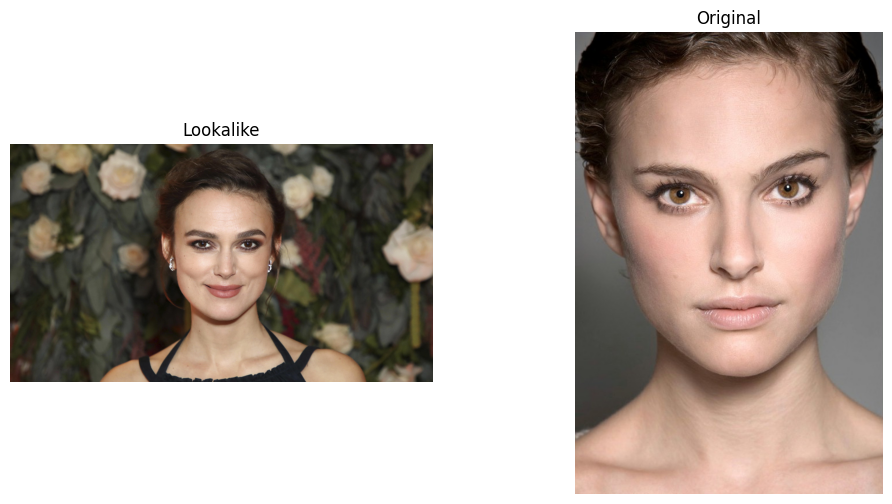

In [11]:
data_female = data_path + '/Female'
data_male = data_path + '/Male'

image_lookalike = np.array(Image.open(data_female + '/F_003_Lookalike.jpg'))
image_original = np.array(Image.open(data_female + '/F_003_Original.jpg'))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image_lookalike)
axs[0].set_title('Lookalike')
axs[0].axis('off')

axs[1].imshow(image_original)
axs[1].set_title('Original')
axs[1].axis('off')

plt.show()

## **Viola-Jones Algorithm**

First, we will resize the images to a cropped square around the face, and then we will change the resolution.

For that, we will implement the Viola-Jones Algorithm, which detects faces in images. We will take inspiration from this website: https://realpython.com/traditional-face-detection-python/


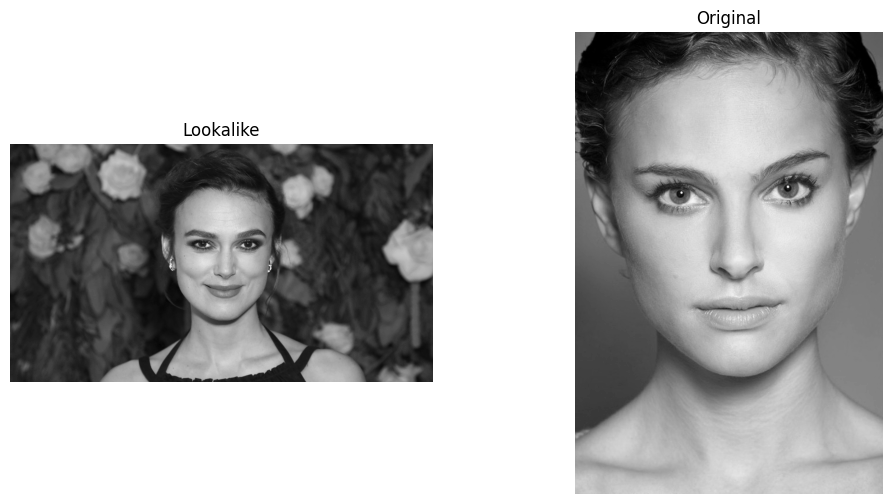

In [12]:
# Convert RGB image to Grayscale
gs_image_lookalike = cv.cvtColor(image_lookalike, cv.COLOR_RGB2GRAY)
gs_image_original = cv.cvtColor(image_original, cv.COLOR_RGB2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(gs_image_lookalike, cmap='gray')
axs[0].set_title('Lookalike')
axs[0].axis('off')

axs[1].imshow(gs_image_original, cmap='gray')
axs[1].set_title('Original')
axs[1].axis('off')

plt.show()

In [13]:
# Get the path to the haarcascades directory
haarcascade_dir = cv.data.haarcascades
haarcascade_path = os.path.join(haarcascade_dir, 'haarcascade_frontalface_alt.xml')

# Load the classifier
face_cascade = cv.CascadeClassifier(haarcascade_path)

# Check if the classifier loaded successfully
if face_cascade.empty():
    raise IOError('Could not load face cascade classifier xml file.')
else:
    print(f'Successfully loaded face cascade classifier from {haarcascade_path}')

Successfully loaded face cascade classifier from /usr/local/lib/python3.10/dist-packages/cv2/data/haarcascade_frontalface_alt.xml


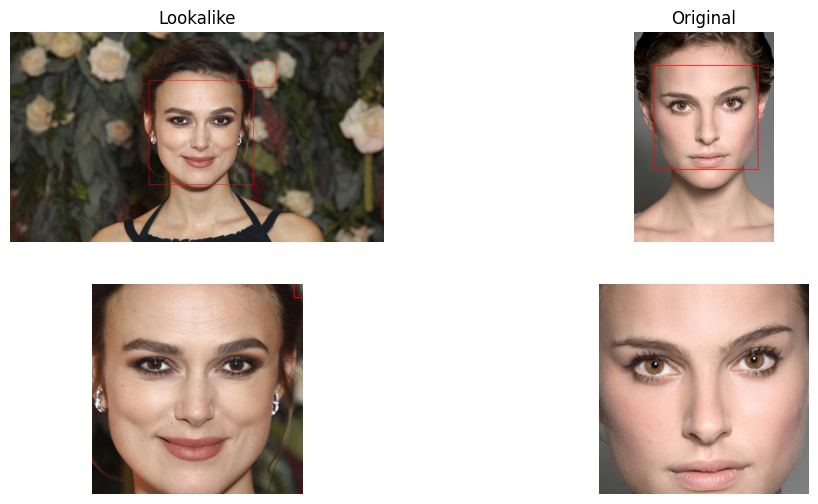

In [14]:
# Apply the classifier
detected_face_lookalike = face_cascade.detectMultiScale(gs_image_lookalike)
detected_face_original = face_cascade.detectMultiScale(gs_image_original)

# Draw a rectangle around the detected face
for (column, row, width, height) in detected_face_lookalike:
    cv.rectangle(
        image_lookalike,
        (column, row),
        (column + width, row + height),
        (255, 0, 0),
        2
    )
    # Crop the image according to the rectangle
    cropped_lookalike = image_lookalike[row+2:row+height-1, column+2:column+width-1]

for (column, row, width, height) in detected_face_original:
    cv.rectangle(
        image_original,
        (column, row),
        (column + width, row + height),
        (255, 0, 0),
        2
    )
    cropped_original = image_original[row+2:row+height-1, column+2:column+width-1]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Display the images with detected faces
axs[0,0].imshow(image_lookalike)
axs[0,0].set_title('Lookalike')
axs[0,0].axis('off')

axs[0,1].imshow(image_original)
axs[0,1].set_title('Original')
axs[0,1].axis('off')

# Display the cropped images
axs[1,0].imshow(cropped_lookalike)
axs[1,0].axis('off')

axs[1,1].imshow(cropped_original)
axs[1,1].axis('off')

plt.show()

Now, as we will see by checking the shapes of the two cropped images, they don't have the same resolution, so we will aply a resize function.

In [15]:
# Resize the resolution
print("Shape of Original Image", cropped_lookalike.shape)
print("Shape of Lookalike Image", cropped_original.shape)

resized_lookalike = cv.resize(cropped_lookalike, (256, 256))
resized_original = cv.resize(cropped_original, (256, 256))

print("\nShape of Resized Original Image", resized_lookalike.shape)
print("Shape of Resized Lookalike Image", resized_original.shape)


Shape of Original Image (663, 663, 3)
Shape of Lookalike Image (393, 393, 3)

Shape of Resized Original Image (256, 256, 3)
Shape of Resized Lookalike Image (256, 256, 3)


## **Data Loader**

Let's implement a Data Loader that will convert every image in the dataset and save the cropped images into new folders, which will be the ones used for training and testing.

In [9]:
class Cropper(torch.utils.data.Dataset):
    def __init__(self, data_path, transform = None):
        self.data_path = data_path
        self.transform = transform

        haarcascade_dir = cv.data.haarcascades
        haarcascade_path = os.path.join(haarcascade_dir, 'haarcascade_frontalface_alt.xml')
        self.face_cascade = cv.CascadeClassifier(haarcascade_path)

        self.file_list = []
        self.labels = []
        for label, folder in enumerate(['Female', 'Male']):
            folder_path = os.path.join(data_path, folder)
            for file_name in os.listdir(folder_path):
                self.file_list.append(os.path.join(folder_path, file_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Convert to grayscale for face detection
        gray_image = cv.cvtColor(np.array(image), cv.COLOR_RGB2GRAY)

        # Detect face
        detected_faces = self.face_cascade.detectMultiScale(gray_image)

        if len(detected_faces) == 1:

            for (column, row, width, height) in detected_faces:
                cropped = image.crop((column, row, column+width, row+height))

                if self.transform:
                    cropped = self.transform(cropped)
                else:
                    cropped = transforms.toTensor()(cropped)

            # Save cropped image to corresponding folders
            folder_name = 'Cropped'
            save_path = os.path.join(self.data_path, folder_name)
            os.makedirs(save_path, exist_ok=True)
            save_file_path = os.path.join(save_path, os.path.basename(img_path))

            if not os.path.exists(save_file_path):
                cropped_image = cropped.permute(1, 2, 0).numpy() * 255
                cropped_image = Image.fromarray(cropped_image.astype(np.uint8))
                cropped_image.save(save_file_path)

            return cropped, label

        return torch.zeros((3, 256, 256)), -1


In [17]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

face_dataset = Cropper(data_path, transform)

batch_size = 32
data_loader = torch.utils.data.DataLoader(face_dataset, batch_size=batch_size, shuffle=True)

total_batches = len(data_loader)

# Iterate over the data loader
for batch_idx, (batch_faces, batch_labels) in enumerate(data_loader):
    print(f"Iteration: {batch_idx+1}/{total_batches}")
    pass

Iteration: 0/24
Iteration: 1/24
Iteration: 2/24
Iteration: 3/24
Iteration: 4/24
Iteration: 5/24
Iteration: 6/24
Iteration: 7/24
Iteration: 8/24
Iteration: 9/24
Iteration: 10/24
Iteration: 11/24
Iteration: 12/24
Iteration: 13/24
Iteration: 14/24
Iteration: 15/24
Iteration: 16/24
Iteration: 17/24
Iteration: 18/24
Iteration: 19/24
Iteration: 20/24
Iteration: 21/24
Iteration: 22/24
Iteration: 23/24
Iteration: 24/24


In [19]:
directory = '/content/drive/My Drive/DeepLearning_2024/FP/HDA-Doppelgaenger/Cropped'

# Lists to store missing files
missing_files = []

# Generate expected filenames
for gender in ['F', 'M']:
    for i in range(1, 201):
        lookalike_filename = f"{gender}_{i:03d}_Lookalike.jpg"
        original_filename = f"{gender}_{i:03d}_Original.jpg"

        if not os.path.isfile(os.path.join(directory, lookalike_filename)):
            missing_files.append(lookalike_filename)
        if not os.path.isfile(os.path.join(directory, original_filename)):
            missing_files.append(original_filename)

# Output missing files
if missing_files:
    print("Missing files:")
    for file in missing_files:
        print(file)

Missing files:
F_003_Lookalike.jpg
F_009_Original.jpg
F_011_Lookalike.jpg
F_013_Lookalike.jpg
F_013_Original.jpg
F_032_Lookalike.jpg
F_032_Original.jpg
F_050_Original.jpg
F_052_Original.jpg
F_062_Lookalike.jpg
F_074_Lookalike.jpg
F_074_Original.jpg
F_080_Lookalike.jpg
F_080_Original.jpg
F_093_Lookalike.jpg
F_097_Lookalike.jpg
F_097_Original.jpg
F_098_Lookalike.jpg
F_098_Original.jpg
F_101_Lookalike.jpg
F_101_Original.jpg
F_111_Lookalike.jpg
F_111_Original.jpg
F_112_Lookalike.jpg
F_112_Original.jpg
F_113_Lookalike.jpg
F_113_Original.jpg
F_114_Lookalike.jpg
F_114_Original.jpg
F_115_Lookalike.jpg
F_115_Original.jpg
F_116_Lookalike.jpg
F_116_Original.jpg
F_117_Lookalike.jpg
F_117_Original.jpg
F_143_Lookalike.jpg
F_144_Lookalike.jpg
F_144_Original.jpg
F_145_Lookalike.jpg
F_146_Original.jpg
F_147_Original.jpg
F_150_Lookalike.jpg
F_153_Original.jpg
F_155_Lookalike.jpg
F_155_Original.jpg
F_160_Lookalike.jpg
F_160_Original.jpg
F_162_Lookalike.jpg
F_162_Original.jpg
F_163_Lookalike.jpg
F_163_Ori

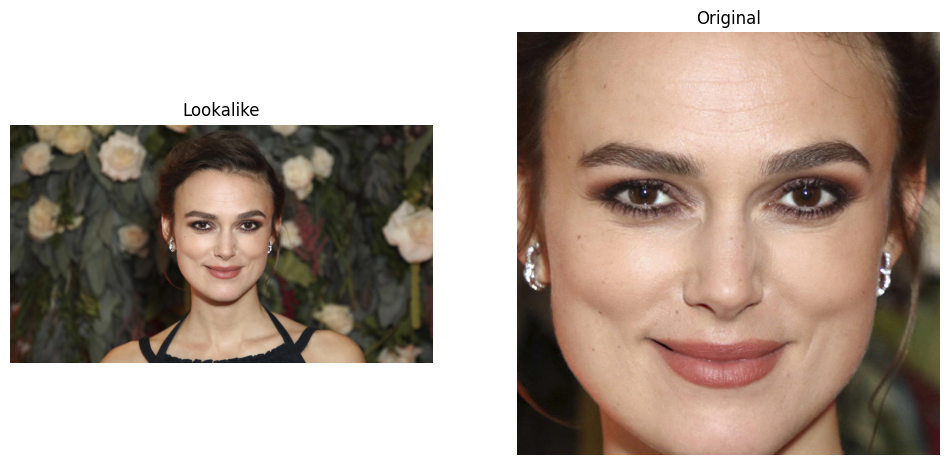

In [21]:
# MANUALLY ADD

image = np.array(Image.open(data_female + '/F_003_Lookalike.jpg'))
gray = cv.cvtColor(image_lookalike, cv.COLOR_RGB2GRAY)
detect = face_cascade.detectMultiScale(gray)

for (column, row, width, height) in detected_face_lookalike:
    crop = image[row:row+height, column:column+width]

resized_lookalike = cv.resize(cropped_lookalike, (256, 256))

################

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image)
axs[0].axis('off')

axs[1].imshow(crop)
axs[1].axis('off')

plt.show()